In [5]:
import os
import sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy import linalg as LA
from nltk.stem import PorterStemmer
#reload(sys)
#sys.setdefaultencoding("utf-8")
import numpy as np
import pandas as pd
import scipy as sc
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [6]:
def get_data(loc):
    ans = {}
    dirs = os.listdir(loc)
    for ind in dirs:
        doc = []
        files = os.listdir(loc+'/'+ind)
        for f in files:
            floc = loc+'/'+ind+'/'+f
            with open(floc, 'r') as content_file:
                content = content_file.read()
                content=str(content).decode('UTF-8', 'ignore')
                doc.append(content)
        ans[ind]=doc
    return ans
val = get_data('q2data/train')

In [12]:
vectorizer = TfidfVectorizer(min_df=2,max_features= 1000,analyzer='word',stop_words='english')
print val.keys()
print "assd"
for d in val.keys():
    docs = val[d]
    # Train the vectorizer on the descriptions
    vectorizer = vectorizer.fit(docs)
for d in val.keys():
    docs = val[d]
    # Convert descriptions to feature vectors
    tfidf = vectorizer.transform(docs)
    tfidf=tfidf.todense()
    tfidf=tfidf.tolist()
    print tfidf[0]
    #print X_tfidf

In [2]:
stop_words = set(stopwords.words('english'))

In [31]:
def get_bow(loc):
    ans = {}
    dirs = os.listdir(loc)
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    df = pd.DataFrame(columns=['label'])
    counter=0
    for ind in dirs:
        files = os.listdir(loc+'/'+ind)
        for f in files:
            df.loc[counter]=0
            df.loc[counter, 'label'] = ind
            floc = loc+'/'+ind+'/'+f
            with open(floc, 'r') as content_file:
                content = content_file.read()
                content=str(content).decode('UTF-8', 'ignore').lower()
                word_tokens = word_tokenize(content)
                filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stop_words and not ps.stem(w) in stop_words and w.isalnum()]
                for word in filtered_sentence:
                    if word not in df.columns:
                        df[word]=0
                    df.loc[counter, word] += 1
            counter += 1
    return df

def add_labels(loc, df):
    ans = {}
    dirs = os.listdir(loc)
    label = []
    for ind in dirs:
        files = os.listdir(loc+'/'+ind)
        for f in files:
            label.append(ind)
    label = np.array(label)
    df['label'] = label
    return


In [4]:
final_bow = get_bow('q2data/train')

In [6]:
final_bow.to_csv("q3_bow.csv", sep=',', encoding='utf-8')

In [7]:
len(final_bow.columns)

17669

In [8]:
copy_bow = final_bow.copy()

In [9]:
copy_bow['label']=0

In [15]:
copy_bow = copy_bow.drop('doc_id', axis=1)

In [19]:
add_labels('q2data/train', dr)

In [20]:
dr.to_csv("q3_bow_final.csv", sep=',', encoding='utf-8')

In [54]:
new_ds_without_label = dr.drop('label', axis=1)

In [55]:
val = new_ds_without_label.values
words = list(new_ds_without_label.columns)

In [20]:
tf_transformer = TfidfTransformer()

In [10]:
print "ass"

In [7]:
dr = pd.read_csv("q3_bow_final.csv", sep=',', encoding='utf-8')

In [8]:
label = np.asmatrix(dr['label']).transpose()

In [52]:
dr = dr.drop('docid', axis=1)

In [56]:
tf_transformer = TfidfTransformer()
r = tf_transformer.fit_transform(val)
np.save('tfidf_reduced', r) 

In [9]:
vectors_load = np.load('tfidf_reduced.npy')

In [10]:
vectors_load

array(<1760x3587 sparse matrix of type '<type 'numpy.float64'>'
	with 215799 stored elements in Compressed Sparse Row format>, dtype=object)

In [11]:
mt = sc.sparse.csc_matrix(vectors_load.all())

In [12]:
mt.shape

(1760, 3587)

In [13]:
tfidf_mat = mt.todense()

In [14]:
tfidf_mat[0]

matrix([[ 0.03474929,  0.05472717,  0.07264261, ...,  0.        ,
          0.        ,  0.        ]])

In [89]:
min_epoch = 5
diff_epoch = 5
max_epoch = 9

def VanillaPerceptron(array, epoch=1):
    n = array.shape[1]
    w = np.zeros(n-1)
    b = 0
    counter=0
    for t in range(epoch):
        for x in array:
            counter+=1
            y_pred = np.dot(x[:-1],w) + b
            if (y_pred * x[-1]) <= 0:
                w += x[:-1] * x[-1]
                b += x[-1]
            #print (counter, w, b)
    return np.append(np.copy(w),b)

def makeitsingular(number, k):
    if number == k:
        return 1
    else:
        return -1

def multiclassPerceptron(array, epoch, numclasses):
    label = array[:,-1].copy()
    w = []
    for k in range(numclasses):
        clas = k
        arr = np.array([makeitsingular(t, clas) for t in label])
        array[:, -1] = arr
        w.append(VanillaPerceptron(array, epoch))
    return w
    
    
def predictVanilla(model, data):
    y = data.copy()
    y = np.append(y,1)
    minh = -10000000000007.0
    pred = 1
    counter = 0
    for m in model:
        val = float(np.dot(m,y))
        if minh < val:
            minh = val
            pred = counter
        counter += 1
    return pred

def merge_arrays(arr):
    out = np.array([])
    #print out.shape
    for r in arr:
        if r.shape[0]==0:
            pass
        elif out.shape[0]==0:
            out = r
        else:
            out = np.concatenate((out, r), axis=0)
    #print out.shape
    return out

def score(test_real, test_pred):
    total = float(len(test_real))
    same = 0.0
    for i in range(len(test_real)):
        if test_real[i]==test_pred[i]:
            same += 1.0
    print same, total
    return float(same/total)

def vanilla_perceptron_model(train, test, epoch=1):
    model = multiclassPerceptron(train.copy(), epoch, 5)
    train_real = train[:,-1]
    train_in = np.delete(train, -1, axis=1)
    train_out = []
    for val in train_in:
        pred = predictVanilla(model, val)
        train_out.append(pred)
    print score(train_real, train_out)
    print "Training Accuracy-> ", score(train_real, train_out)
    test_in = np.delete(test, -1, axis=1)
    test_out = []
    for val in test_in:
        pred = predictVanilla(model, val)
        test_out.append(pred)
    test_real = test[:,-1]
    return score(test_real, test_out)

def sign(num):
    if num<=0:
        return -1
    else:
        return 1
    
def perceptron_cross_valid(arr, string):
    k = 5
    r = np.copy(arr)
    np.random.shuffle(r)
    split_arr = np.asarray(np.array_split(r, k))
    acc_mat = []
    for i in xrange(min_epoch, max_epoch+1, diff_epoch):
        ans_arr = []
        for j in range(k):
            test_arr = split_arr[j]
            train_arr = merge_arrays(split_arr[:j])
            t = merge_arrays(split_arr[j+1:])
            train_arr = merge_arrays([train_arr,t])
            if string=="voted":
                accuracy = voted_perceptron_model(train_arr, test_arr, i)
            elif string=="vanilla":
                accuracy = vanilla_perceptron_model(train_arr, test_arr, i)
            ans_arr.append(accuracy)
        larr = np.array(ans_arr)
        print ("Epoch {0} -> {1} +/- {2}").format(i, larr.mean(), 2*larr.std())
        acc_mat.append(larr.mean())
    return acc_mat

In [41]:
dataset = np.append(tfidf_mat, label, axis=1)

In [47]:
r[:,-1]

matrix([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.04580621]])

In [90]:
model = perceptron_cross_valid(np.asarray(dataset), "vanilla")

1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
339.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
338.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
334.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
326.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
335.0 352.0
Epoch 5 -> 0.95 +/- 0.0260621475936


In [61]:
np.asarray(dataset)[:,1000]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [62]:
w = multiclassPerceptron(np.asarray(dataset).copy(),1, 5)

In [55]:
# k = 10
model

[0.74829545454545454,
 0.7488636363636364,
 0.7488636363636364,
 0.7488636363636364]

In [14]:
# k = 5
model

[0.74147727272727271,
 0.74090909090909096,
 0.74090909090909096,
 0.74090909090909096]

In [140]:
def find_category_count(array):
    arr = [0,0,0,0,0]
    min2=0
    ans = 1
    for r in array:
        e = int(r[1])
        arr[e] += 1
        if min2<arr[e]:
            min2=arr[e]
            ans=e
    return ans
    

def cosine_score(test_real, test_pred):
    total = float(len(test_real))
    same = 0.0
    for i in range(len(test_real)):
        if test_real[i]==test_pred[i]:
            same += 1.0
    return float(same/total)    
    
def cosine_model(train_arr, test_arr):
    ret = []
    test_arr2 = test_arr[:,:-1]
    test_real = test_arr[:,-1]
    for test in test_arr2:
        res  = []
        for train in train_arr:
            cos_val = 0
            val = np.dot(test, train[:-1])
            test_abs = LA.norm(test,2)
            train_abs = LA.norm(train,2)
            if test_abs !=0 and train_abs !=0:
                cos_val = 1-sc.spatial.distance.cosine(test, train[:-1])
            tup = (cos_val, train[-1])
            res.append(tup)
        res.sort(key=lambda tup: tup[0])
        data = res[-10:]
        del res
        cat = find_category_count(data)
        ret.append(cat)
    return cosine_score(test_real, ret)
        

def cosine_cross_valid(arr):
    k = 5
    r = np.copy(arr)
    np.random.shuffle(r)
    split_arr = np.asarray(np.array_split(r, k))
    acc_mat = []
    ans_arr = []
    for j in range(k):
        test_arr = split_arr[j]
        train_arr = merge_arrays(split_arr[:j])
        t = merge_arrays(split_arr[j+1:])
        train_arr = merge_arrays([train_arr,t])
        accuracy = cosine_model(train_arr, test_arr)
        ans_arr.append(accuracy)
    larr = np.array(ans_arr)
    print (larr)
    print ("{0} +/- {1}").format(larr.mean(), 2*larr.std())
    acc_mat.append(larr.mean())
    return acc_mat

    

In [6]:
vectors_load = np.load('tfidf_with_label.npy')
mt = sc.sparse.csc_matrix(vectors_load.all())
dataset = mt.todense()

In [91]:
cosine_cross_valid(np.asarray(dataset))

[ 0.60511364  0.63068182  0.64772727  0.63068182  0.67045455]
0.636931818182 +/- 0.0431818181818


[0.63693181818181821]

In [14]:
np.save('tfidf_with_label', sc.sparse.csc_matrix(dataset)) 

In [ ]:
def calculatesvd(mat):
    AAt = np.matmul(mat, mat.transpose())
    AtA = np.matmul(mat.transpose(), mat)
    return
calculatesvd(dataset[:,:-1])

In [7]:
from scipy import linalg
U, s, Vh = linalg.svd(dataset[:,:-1].transpose(), full_matrices=False)

In [5]:
Vh.shape

(1760, 1760)

In [9]:
S = linalg.diagsvd(s, 1760, 1760)

In [10]:
S_r = S[:-1000,:-1000]

In [11]:
U_r = U[:,:-1000]

In [12]:
Vh_r = Vh[1000:,:]

In [19]:
Vh_r.shape

(1760, 1760)

In [13]:
R = np.matmul(U_r, np.matmul(S_r, Vh_r))

In [22]:
R = R.transpose()

In [38]:
cosine_cross_valid(np.asarray(newm))

KeyboardInterrupt: 

In [24]:
reduced = np.append(reduced, label, axis=1)

In [17]:
R.shape

(1760, 17668)

In [61]:
S[200,200]

1.3444587703222568

In [62]:
newm = dataset[:,:-1].transpose()

In [21]:
R = np.matmul(U.transpose(), R)

In [70]:
dataset[:,-1]

matrix([[ 3.],
        [ 3.],
        [ 3.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]])

In [44]:
A = csc_matrix(dataset[:,:-1], dtype=float)

In [53]:
u, s, vt = svds(A, k=1700)

In [50]:
vt.shape

(6, 17667)

In [63]:
S[100,100]

1.6179297336478815

In [34]:
model = perceptron_cross_valid(np.asarray(dataset), "vanilla")

Epoch 5 -> 0.745454545455 +/- 0.0332471337235
Epoch 10 -> 0.744886363636 +/- 0.0328171115413
Epoch 15 -> 0.744886363636 +/- 0.0328171115413
Epoch 20 -> 0.744886363636 +/- 0.0328171115413


In [23]:
reduced = R

In [27]:
reduced.shape

(1760, 1761)

In [33]:
dataset.shape

(1760, 17668)

In [61]:
minf = 0
diff = 20
maxf = 1660
def check_on_various_features(dataset):
    U, s, Vh = linalg.svd(dataset[:,:-1].transpose(), full_matrices=False)
    S = linalg.diagsvd(s, 1760, 1760)
    ans = []
    for w in xrange(minf, maxf, diff):
        if w !=0 :
            S_r = S[:-1*w,:-1*w]
            U_r = U[:,:-1*w]
            Vh_r = Vh[w:,:]
        else:
            S_r = S[:,:]
            U_r = U[:,:]
            Vh_r = Vh[:,:]
        R = np.matmul(U_r, np.matmul(S_r, Vh_r))
        R = np.matmul(U_r.transpose(), R)
        R = R.transpose()
        reduced = np.append(R, dataset[:,-1], axis=1)
        accuracy = perceptron_cross_valid(np.asarray(reduced), "vanilla")
        print accuracy
        ans.append(accuracy)
    return ans
res = check_on_various_features(dataset)

Epoch 1 -> 0.713068181818 +/- 0.0661633028546
[0.71306818181818188]
Epoch 1 -> 0.184659090909 +/- 0.0362925441424
[0.18465909090909091]
Epoch 1 -> 0.196022727273 +/- 0.0601307116151
[0.19602272727272727]
Epoch 1 -> 0.0806818181818 +/- 0.0245307194829
[0.080681818181818188]
Epoch 1 -> 0.0903409090909 +/- 0.100835866143
[0.090340909090909083]
Epoch 1 -> 0.0551136363636 +/- 0.0284318090982
[0.055113636363636365]
Epoch 1 -> 0.0585227272727 +/- 0.0330523626642
[0.058522727272727268]
Epoch 1 -> 0.113636363636 +/- 0.0948710521125
[0.11363636363636362]
Epoch 1 -> 0.0755681818182 +/- 0.0338247183321
[0.075568181818181812]
Epoch 1 -> 0.0909090909091 +/- 0.0655751729375
[0.090909090909090898]
Epoch 1 -> 0.0727272727273 +/- 0.0442452780317
[0.072727272727272724]
Epoch 1 -> 0.0744318181818 +/- 0.0570902576685
[0.074431818181818182]
Epoch 1 -> 0.144886363636 +/- 0.0753778361444
[0.14488636363636365]
Epoch 1 -> 0.165909090909 +/- 0.127789130929
[0.16590909090909092]
Epoch 1 -> 0.0903409090909 +/- 0.0

In [59]:
print res

[[0.72556818181818183], [0.12897727272727272], [0.066477272727272732], [0.12954545454545455], [0.12386363636363637], [0.10340909090909089], [0.085795454545454536], [0.11874999999999999], [0.15170454545454545], [0.10397727272727272], [0.12954545454545455], [0.12045454545454545], [0.098863636363636376], [0.20170454545454547], [0.19261363636363635], [0.14488636363636362], [0.15340909090909091]]


In [42]:
dataset.shape

(1760, 17668)

In [62]:
ans2 = res

In [63]:
ans2

[[0.71306818181818188],
 [0.18465909090909091],
 [0.19602272727272727],
 [0.080681818181818188],
 [0.090340909090909083],
 [0.055113636363636365],
 [0.058522727272727268],
 [0.11363636363636362],
 [0.075568181818181812],
 [0.090909090909090898],
 [0.072727272727272724],
 [0.074431818181818182],
 [0.14488636363636365],
 [0.16590909090909092],
 [0.090340909090909083],
 [0.10625],
 [0.1255681818181818],
 [0.077840909090909099],
 [0.10227272727272727],
 [0.059659090909090905],
 [0.078977272727272729],
 [0.10795454545454548],
 [0.11136363636363637],
 [0.060227272727272727],
 [0.10284090909090908],
 [0.078977272727272729],
 [0.18238636363636365],
 [0.089204545454545453],
 [0.10000000000000001],
 [0.050000000000000003],
 [0.10738636363636363],
 [0.076136363636363627],
 [0.038636363636363635],
 [0.099431818181818177],
 [0.11590909090909092],
 [0.18181818181818182],
 [0.067613636363636362],
 [0.071022727272727279],
 [0.078977272727272729],
 [0.075568181818181812],
 [0.13011363636363635],
 [0.11

In [65]:
s[:-1]

array([  7.74291978e+00,   4.52184419e+00,   4.14397976e+00, ...,
         2.31572298e-16,   2.06666005e-16,   1.77391490e-16])

In [73]:
minf = 0
diff = 100
maxf = 1660
def check_on_various_features(dataset):
    U, s, Vh = linalg.svd(dataset[:,:-1].transpose(), full_matrices=False)
    S = linalg.diagsvd(s, 1760, 1760)
    ans = []
    for w in xrange(minf, maxf, diff):
        if w !=0 :
            S_r = S[:-1*w,:-1*w]
            U_r = U[:,:-1*w]
            Vh_r = Vh[w:,:]
        else:
            S_r = S[:,:]
            U_r = U[:,:]
            Vh_r = Vh[:,:]
        #R = np.matmul(U_r, np.matmul(S_r, Vh_r))
        #R = np.matmul(U_r.transpose(), R)
        R = np.matmul(S_r, Vh_r)
        R = R.transpose()
        reduced = np.append(R, dataset[:,-1], axis=1)
        accuracy = cosine_cross_valid(np.asarray(reduced))
        print accuracy
        ans.append(accuracy)
    return ans
cosine_res = check_on_various_features(dataset)

[ 0.72443182  0.65625     0.71306818  0.6875      0.68181818]
0.692613636364 +/- 0.048131405874
[0.69261363636363638]
[ 0.28409091  0.30965909  0.26988636  0.25568182  0.28977273]
0.281818181818 +/- 0.0365407617973
[0.28181818181818186]


KeyboardInterrupt: 

In [69]:
Vh_r.shape

(1760, 1760)

In [72]:
ans3 = cosine_res

In [13]:
tr = vectors_load.transpose()

In [22]:
vectors_load

array(<1760x17667 sparse matrix of type '<type 'numpy.float64'>'
	with 248752 stored elements in Compressed Sparse Row format>, dtype=object)

In [45]:
count=0
for r in dr.columns:
    if dr[dr[r]!=0].shape[0] < 10 and r!="doc_id" and r!="label":
        dr = dr.drop(r, axis=1)

In [49]:
dr.shape

(1760, 3589)

In [27]:
dr.shape

(1760, 17669)

In [38]:
dr

,stroll,rooney,cruis,quinton,cristiano,silenc,jeer,goodison,martyn,parri,...,hadi,blackwatch,22bn,pharmaci,bechtel,halliburton,uneasili,multin,baathist,kirkuk
0,1,7,1,1,1,1,2,2,8,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,14,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
dr.shape

(1760, 14270)

In [44]:
dr.shape

(1760, 17669)

In [50]:
dr.to_csv("q3_reduced_final.csv", sep=',', encoding='utf-8')

In [68]:
model = perceptron_cross_valid(np.asarray(dataset), "vanilla")

Epoch 1 -> 0.719886363636 +/- 0.0270349483031


In [74]:
from scipy import linalg
AAt = np.matmul(dataset[:,:-1].transpose(),dataset[:,:-1])

In [127]:
w, v = linalg.eig(AAt)

In [131]:
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

In [123]:
minf = 3487
diff = 1
maxf = 3587
def check_on_various_features(dataset, v):
    ans = []
    for w in xrange(minf, maxf, diff):
        U = v[:,:-1*w]
        R = np.matmul(dataset[:,:-1], U)
        reduced = np.append(R, dataset[:,-1], axis=1)
        accuracy = perceptron_cross_valid(np.asarray(reduced), "vanilla")
        print accuracy
        ans.append(accuracy)
    return ans
res = check_on_various_features(dataset , v.astype('float'))

NameError: name 'v' is not defined

In [90]:
v.astype('float')

/home/satyam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([[-0.02152392,  0.0119644 ,  0.01879917, ...,  0.00988635,
         0.01279521,  0.05490155],
       [-0.00400156,  0.00356403,  0.00646058, ...,  0.00129021,
         0.00897928, -0.03430964],
       [-0.02786301,  0.0731542 ,  0.05959997, ...,  0.00051804,
         0.01831228,  0.04376476],
       ..., 
       [-0.00764323, -0.01037999, -0.01707368, ...,  0.00775775,
         0.00968716, -0.00282727],
       [-0.00632705, -0.00269033, -0.01016066, ..., -0.00830252,
         0.00024034,  0.00754303],
       [-0.00243258, -0.00252347, -0.00521338, ..., -0.00083318,
        -0.01337971, -0.01725012]])

In [151]:
lenf = []
for w in xrange(minf, maxf, diff):
    lenf.append(dataset.shape[1]-1-w)

In [102]:
lenf

[6, 5, 4, 3, 2, 1]

In [96]:
dataset.shape

(1760, 3588)

In [98]:
arr1 = res
len1= lenf

In [120]:
ans_final

[[0.73011363636363635],
 [0.73409090909090913],
 [0.72045454545454546],
 [0.72670454545454544],
 [0.74034090909090922],
 [0.74147727272727271],
 [0.7369318181818183],
 [0.73579545454545459],
 [0.69999999999999996],
 [0.73579545454545459],
 [0.72329545454545463],
 [0.73011363636363635],
 [0.7210227272727272],
 [0.73465909090909087],
 [0.72727272727272729],
 [0.7079545454545455],
 [0.72784090909090904],
 [0.72329545454545452],
 [0.72840909090909089],
 [0.74261363636363631],
 [0.73295454545454541],
 [0.73977272727272736],
 [0.72272727272727266],
 [0.73352272727272727],
 [0.7164772727272728],
 [0.72727272727272729],
 [0.72499999999999998],
 [0.72897727272727264],
 [0.72784090909090915],
 [0.73011363636363635],
 [0.66420454545454555],
 [0.71477272727272712],
 [0.72499999999999998],
 [0.72045454545454546],
 [0.70852272727272725],
 [0.73806818181818179],
 [0.73977272727272725],
 [0.74659090909090908],
 [0.70795454545454539],
 [0.73693181818181819],
 [0.74034090909090899],
 [0.7221590909090909

In [115]:
ans_final = arr1+res
len_final = len1+lenf


In [116]:
len_final

[3567,
 3547,
 3527,
 3507,
 3487,
 3467,
 3447,
 3427,
 3407,
 3387,
 3367,
 3347,
 3327,
 3307,
 3287,
 3267,
 3247,
 3227,
 3207,
 3187,
 3167,
 3147,
 3127,
 3107,
 3087,
 3067,
 3047,
 3027,
 3007,
 2987,
 2967,
 2947,
 2927,
 2907,
 2887,
 2867,
 2847,
 2827,
 2807,
 2787,
 2767,
 2747,
 2727,
 2707,
 2687,
 2667,
 2647,
 2627,
 2607,
 2587,
 2567,
 2547,
 2527,
 2507,
 2487,
 2467,
 2447,
 2427,
 2407,
 2387,
 2367,
 2347,
 2327,
 2307,
 2287,
 2267,
 2247,
 2227,
 2207,
 2187,
 2167,
 2147,
 2127,
 2107,
 2087,
 2067,
 2047,
 2027,
 2007,
 1987,
 1967,
 1947,
 1927,
 1907,
 1887,
 1867,
 1847,
 1827,
 1807,
 1787,
 1767,
 1747,
 1727,
 1707,
 1687,
 1667,
 1647,
 1627,
 1607,
 1587,
 1567,
 1547,
 1527,
 1507,
 1487,
 1467,
 1447,
 1427,
 1407,
 1387,
 1367,
 1347,
 1327,
 1307,
 1287,
 1267,
 1247,
 1227,
 1207,
 1187,
 1167,
 1147,
 1127,
 1107,
 1087,
 1067,
 1047,
 1027,
 1007,
 987,
 967,
 947,
 927,
 907,
 887,
 867,
 847,
 827,
 807,
 787,
 767,
 747,
 727,
 707,
 687,
 

In [137]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

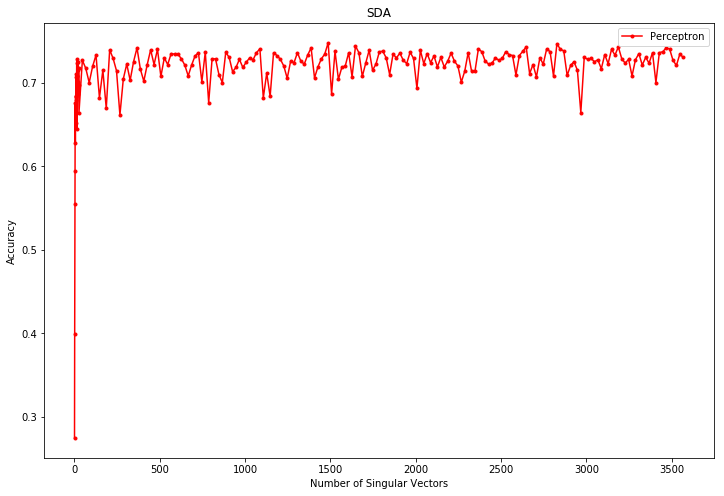

In [122]:
fig = plt.figure()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(len_final,ans_final , '.r-', label='Perceptron')
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SDA')
plt.savefig("q3_a.jpg")
plt.show()

In [149]:
w[:-10]

array([  8.39793111e+01 +0.00000000e+00j,
         2.60417545e+01 +0.00000000e+00j,
         2.27286760e+01 +0.00000000e+00j, ...,
        -1.02945282e-15 +1.83905525e-16j,
        -1.02945282e-15 -1.83905525e-16j,  -1.03981621e-15 +3.62514247e-16j])

In [128]:
idx = w.argsort()[::-1]   

In [130]:
w[idx]

array([  8.39793111e+01 +0.00000000e+00j,
         2.60417545e+01 +0.00000000e+00j,
         2.27286760e+01 +0.00000000e+00j, ...,
        -1.22715412e-15 -2.64556874e-17j,
        -1.51084916e-15 +0.00000000e+00j,  -2.54671575e-15 +0.00000000e+00j])

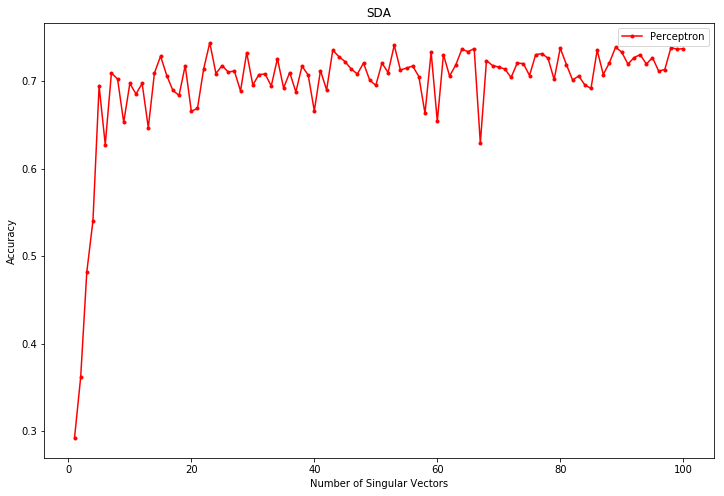

In [152]:
fig = plt.figure()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(lenf,res , '.r-', label='Perceptron')
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SDA')
plt.savefig("q3_a2.jpg")
plt.show()

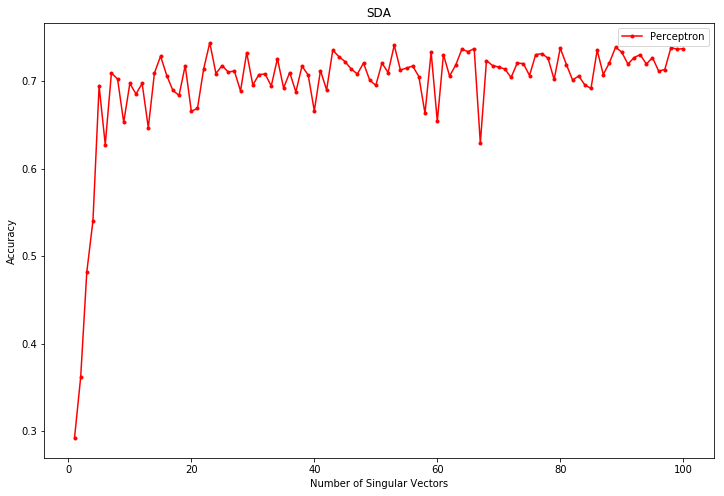

In [168]:
# 23 features performing best
fig = plt.figure()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(lenf,res , '.r-', label='Perceptron')
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SDA')
plt.savefig("q3_a2.jpg")
plt.show()

In [161]:
minf = 3587
diff = 1
maxf = 3588
def check_on_various_features(dataset, v):
    ans = []
    for w in xrange(minf, maxf, diff):
        U = v[:,:-1*w]
        R = np.matmul(dataset[:,:-1], U)
        reduced = np.append(R, dataset[:,-1], axis=1)
        accuracy = cosine_cross_valid(np.asarray(reduced))
        print accuracy
        ans.append(accuracy)
    return ans
cosine_res = check_on_various_features(dataset, v.astype('float'))

/home/satyam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


[ 0.22443182  0.22727273  0.18465909  0.22727273  0.21306818]
0.215340909091 +/- 0.032421233222
[0.21534090909090908]


In [169]:
dataset.shape

(1760, 3588)

In [173]:
cosine_res

[[0.63522727272727264],
 [0.65056818181818188],
 [0.63749999999999996],
 [0.63863636363636367],
 [0.64090909090909087],
 [0.62102272727272723],
 [0.58863636363636362],
 [0.37272727272727268]]

In [184]:
lenf = []
for w in xrange(minf, maxf, diff):
    lenf.append(dataset.shape[1]-1-w)

In [175]:
ans1= cosine_res

In [176]:
len1 = lenf

In [187]:
fans = ans1[:-1]+cosine_res

In [188]:
flen = len1[:-1]+lenf

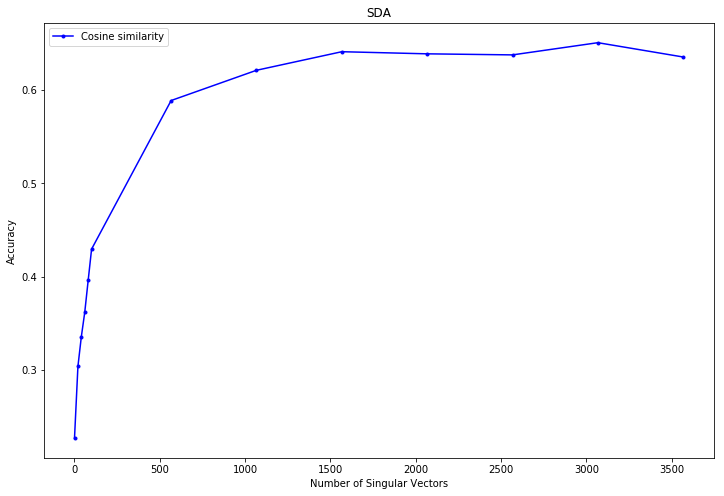

In [191]:
# 23 features performing best
fig = plt.figure()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(flen,fans , '.b-', label='Cosine similarity')
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SDA')
plt.savefig("q3_b1.jpg")
plt.show()

In [213]:
# 23 features performing best
fig, ax = plt.subplots()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(flen,fans , '.b-', label='Cosine similarity')
plt.plot(len_final,ans_final , '.r-', label='Perceptron')
ax.xaxis.set_major_locator(MultipleLocator(200))
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SDA')
plt.savefig("q3_res2.jpg")
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'set_scale'

In [193]:
len1

[3567, 3067, 2567, 2067, 1567, 1067, 567, 67]

In [194]:
lenf

[101, 81, 61, 41, 21, 1]

In [20]:
dataset[:,-1]

matrix([[ 3.],
        [ 3.],
        [ 3.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]])

In [92]:
final_bow = pd.read_csv("q3/q3_dataset.csv", sep=',', encoding='utf-8')

In [93]:
final_bow.shape

(1760, 17672)

In [113]:
def drop_words(dr):
    count=0
    arr = []
    for r in dr.columns:
        if dr[dr[r]!=0].shape[0] < 10 and r not in ['doc_id','DB:label','label_set','DB:loc']:
            arr.append(r)
        count+=1
    return arr

In [114]:
ref = drop_words(final_bow)

In [115]:
dr = final_bow
dr = dr.drop(ref, axis=1)

In [117]:
dr.shape

(1760, 3592)

In [121]:
dr.to_csv("q3/q3_dataset_reduced.csv", sep=',', encoding='utf-8')

In [122]:
final_bow = dr
new_ds_without_label = final_bow.drop(['doc_id','DB:label','label_set','DB:loc'], axis=1)
val = new_ds_without_label.values
words = list(new_ds_without_label.columns)
tf_transformer = TfidfTransformer()
vectors_load = tf_transformer.fit_transform(val)
mt = sc.sparse.csc_matrix(vectors_load)
tfidf_mat = mt.todense()
dataset = np.append(tfidf_mat, label, axis=1)
np.save('q3/tfidf_reduced', sc.sparse.csc_matrix(dataset))

In [125]:
from scipy import linalg
def check_on_various_features(dataset, minf, diff, maxf, v):
    ans = []
    for w in xrange(minf, maxf, diff):
        U = v[:,:-1*w]
        R = np.matmul(dataset[:,:-1], U)
        reduced = np.append(R, dataset[:,-1], axis=1)
        accuracy = perceptron_cross_valid(np.asarray(reduced), "vanilla")
        print accuracy
        ans.append(accuracy)
    return ans

AAt = np.matmul(dataset[:,:-1].transpose(),dataset[:,:-1])
w, v = linalg.eig(AAt)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
res = check_on_various_features(dataset,20,20,3560,v)

TypeError: Cannot cast ufunc add output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [126]:
res = check_on_various_features(dataset,20,20,3560,v.astype('float'))

/home/satyam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
338.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
332.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
335.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
332.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
330.0 352.0
Epoch 5 -> 0.947159090909 +/- 0.0159090909091
[0.94715909090909101]
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
322.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
331.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
334.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
338.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
334.0 352.0
Epoch 5 -> 0.942613636364 +/- 0.0305764182888
[0.94261363636363638

1401.0 1408.0
0.995028409091
Training Accuracy->  1401.0 1408.0
0.995028409091
337.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
323.0 352.0
1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
328.0 352.0
Epoch 5 -> 0.936931818182 +/- 0.0262595909279
[0.93693181818181814]
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
331.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
344.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
337.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
335.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
333.0 352.0
Epoch 5 -> 0.954545454545 +/- 0.0254098633807
[0.95454545454545447]
1401.0 1408.0
0.995028409091
Training Accuracy->  1401.0 1408.0
0.995028409091
330.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0

1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
340.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
333.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
340.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
336.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
339.0 352.0
Epoch 5 -> 0.959090909091 +/- 0.0154979337466
[0.95909090909090922]
1401.0 1408.0
0.995028409091
Training Accuracy->  1401.0 1408.0
0.995028409091
330.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
333.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
337.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
337.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
328.0 352.0
Epoch 5 -> 0.946022727273 +/- 0.0206430705961
[0.94602272727272729

1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
337.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
336.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
343.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
328.0 352.0
Epoch 5 -> 0.948295454545 +/- 0.0368924615472
[0.94829545454545472]
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
337.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
331.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
341.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
337.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
336.0 352.0
Epoch 5 -> 0.955681818182 +/- 0.0181818181818
[0.95568181818181819]
1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
335.0 352.0
1404.0 1408.0
0.9971

1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
336.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
344.0 352.0
Epoch 5 -> 0.95625 +/- 0.0291051101701
[0.95625000000000004]
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
337.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
337.0 352.0
1391.0 1408.0
0.987926136364
Training Accuracy->  1391.0 1408.0
0.987926136364
328.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
339.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
328.0 352.0
Epoch 5 -> 0.948295454545 +/- 0.0272253376153
[0.9482954545454545]
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
339.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
332.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
339.0 352.0
1393.0

1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
337.0 352.0
1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
337.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
331.0 352.0
Epoch 5 -> 0.949431818182 +/- 0.0318181818182
[0.94943181818181821]
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
334.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
339.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
336.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
332.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
333.0 352.0
Epoch 5 -> 0.951136363636 +/- 0.0141019018704
[0.95113636363636367]
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
328.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
330.0 352.

1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
335.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
336.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
334.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
333.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
331.0 352.0
Epoch 5 -> 0.948295454545 +/- 0.00977536962164
[0.9482954545454545]
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
336.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
337.0 352.0
1397.0 1408.0
0.9921875
Training Accuracy->  1397.0 1408.0
0.9921875
324.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
336.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
329.0 352.0
Epoch 5 -> 0.944318181818 +/- 0.0288824205162
[0.94431

1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
329.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
335.0 352.0
1392.0 1408.0
0.988636363636
Training Accuracy->  1392.0 1408.0
0.988636363636
331.0 352.0
Epoch 5 -> 0.9375 +/- 0.0160706086633
[0.9375]
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
329.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
338.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
337.0 352.0
1401.0 1408.0
0.995028409091
Training Accuracy->  1401.0 1408.0
0.995028409091
338.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
340.0 352.0
Epoch 5 -> 0.955681818182 +/- 0.0217399164429
[0.95568181818181819]
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
331.0 352.0
1400.0 1408.0
0.994318181818
Training Accuracy->  1400.0 1408.0
0.994318181818
333.0 352.0
1407.0 1408.0
0.999289772727
Training Acc

1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
339.0 352.0
1408.0 1408.0
1.0
Training Accuracy->  1408.0 1408.0
1.0
338.0 352.0
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
329.0 352.0
Epoch 5 -> 0.950568181818 +/- 0.0223260030732
[0.95056818181818181]
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
341.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
343.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
335.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
324.0 352.0
1397.0 1408.0
0.9921875
Training Accuracy->  1397.0 1408.0
0.9921875
334.0 352.0
Epoch 5 -> 0.952840909091 +/- 0.0377915662462
[0.95284090909090913]
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.997869318182
340.0 352.0
1405.0 1408.0
0.997869318182
Training Accuracy->  1405.0 1408.0
0.99786931818

331.0 352.0
1401.0 1408.0
0.995028409091
Training Accuracy->  1401.0 1408.0
0.995028409091
340.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
340.0 352.0
Epoch 5 -> 0.957954545455 +/- 0.0194845774994
[0.9579545454545455]
1406.0 1408.0
0.998579545455
Training Accuracy->  1406.0 1408.0
0.998579545455
339.0 352.0
1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
341.0 352.0
1399.0 1408.0
0.993607954545
Training Accuracy->  1399.0 1408.0
0.993607954545
339.0 352.0
1404.0 1408.0
0.997159090909
Training Accuracy->  1404.0 1408.0
0.997159090909
340.0 352.0
1402.0 1408.0
0.995738636364
Training Accuracy->  1402.0 1408.0
0.995738636364
333.0 352.0
Epoch 5 -> 0.961363636364 +/- 0.0159090909091
[0.96136363636363631]
1392.0 1408.0
0.988636363636
Training Accuracy->  1392.0 1408.0
0.988636363636
339.0 352.0
1407.0 1408.0
0.999289772727
Training Accuracy->  1407.0 1408.0
0.999289772727
338.0 352.0
1398.0 1408.0
0.992897727273
Train

1390.0 1408.0
0.987215909091
Training Accuracy->  1390.0 1408.0
0.987215909091
332.0 352.0
1397.0 1408.0
0.9921875
Training Accuracy->  1397.0 1408.0
0.9921875
342.0 352.0
Epoch 5 -> 0.939204545455 +/- 0.0409090909091
[0.93920454545454546]
1398.0 1408.0
0.992897727273
Training Accuracy->  1398.0 1408.0
0.992897727273
340.0 352.0
1398.0 1408.0
0.992897727273
Training Accuracy->  1398.0 1408.0
0.992897727273
332.0 352.0
1372.0 1408.0
0.974431818182
Training Accuracy->  1372.0 1408.0
0.974431818182
339.0 352.0
1403.0 1408.0
0.996448863636
Training Accuracy->  1403.0 1408.0
0.996448863636
335.0 352.0
1397.0 1408.0
0.9921875
Training Accuracy->  1397.0 1408.0
0.9921875
336.0 352.0
Epoch 5 -> 0.955681818182 +/- 0.0163098864709
[0.95568181818181819]
1398.0 1408.0
0.992897727273
Training Accuracy->  1398.0 1408.0
0.992897727273
336.0 352.0
1379.0 1408.0
0.979403409091
Training Accuracy->  1379.0 1408.0
0.979403409091
337.0 352.0
1392.0 1408.0
0.988636363636
Training Accuracy->  1392.0 1408.0
0

In [127]:
res

[[0.94715909090909101],
 [0.94261363636363638],
 [0.95113636363636367],
 [0.95170454545454553],
 [0.95170454545454553],
 [0.94545454545454555],
 [0.94545454545454533],
 [0.94943181818181821],
 [0.94147727272727266],
 [0.94829545454545472],
 [0.94318181818181812],
 [0.95056818181818203],
 [0.95397727272727262],
 [0.95340909090909098],
 [0.94545454545454555],
 [0.95227272727272716],
 [0.93693181818181814],
 [0.95454545454545447],
 [0.94659090909090915],
 [0.93863636363636371],
 [0.94261363636363638],
 [0.94886363636363635],
 [0.95113636363636367],
 [0.94488636363636369],
 [0.94886363636363635],
 [0.95113636363636367],
 [0.94602272727272729],
 [0.95511363636363633],
 [0.95056818181818181],
 [0.94602272727272718],
 [0.94659090909090904],
 [0.95056818181818181],
 [0.94772727272727286],
 [0.95909090909090922],
 [0.94602272727272729],
 [0.95113636363636367],
 [0.95113636363636367],
 [0.94829545454545472],
 [0.9579545454545455],
 [0.94147727272727266],
 [0.94431818181818161],
 [0.9460227272727

In [128]:
def singularvector(minf,diff,maxf):
    lenf = []
    for w in xrange(minf, maxf, diff):
        lenf.append(dataset.shape[1]-1-w)
    return lenf

In [129]:
ans1 = res
len1 = singularvector(20,20,3560)

In [130]:
len1

[3568,
 3548,
 3528,
 3508,
 3488,
 3468,
 3448,
 3428,
 3408,
 3388,
 3368,
 3348,
 3328,
 3308,
 3288,
 3268,
 3248,
 3228,
 3208,
 3188,
 3168,
 3148,
 3128,
 3108,
 3088,
 3068,
 3048,
 3028,
 3008,
 2988,
 2968,
 2948,
 2928,
 2908,
 2888,
 2868,
 2848,
 2828,
 2808,
 2788,
 2768,
 2748,
 2728,
 2708,
 2688,
 2668,
 2648,
 2628,
 2608,
 2588,
 2568,
 2548,
 2528,
 2508,
 2488,
 2468,
 2448,
 2428,
 2408,
 2388,
 2368,
 2348,
 2328,
 2308,
 2288,
 2268,
 2248,
 2228,
 2208,
 2188,
 2168,
 2148,
 2128,
 2108,
 2088,
 2068,
 2048,
 2028,
 2008,
 1988,
 1968,
 1948,
 1928,
 1908,
 1888,
 1868,
 1848,
 1828,
 1808,
 1788,
 1768,
 1748,
 1728,
 1708,
 1688,
 1668,
 1648,
 1628,
 1608,
 1588,
 1568,
 1548,
 1528,
 1508,
 1488,
 1468,
 1448,
 1428,
 1408,
 1388,
 1368,
 1348,
 1328,
 1308,
 1288,
 1268,
 1248,
 1228,
 1208,
 1188,
 1168,
 1148,
 1128,
 1108,
 1088,
 1068,
 1048,
 1028,
 1008,
 988,
 968,
 948,
 928,
 908,
 888,
 868,
 848,
 828,
 808,
 788,
 768,
 748,
 728,
 708,
 688,
 

In [132]:
res = check_on_various_features(dataset,3550,1,3588,v.astype('float'))

/home/satyam/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


1252.0 1408.0
0.889204545455
Training Accuracy->  1252.0 1408.0
0.889204545455
324.0 352.0
1330.0 1408.0
0.944602272727
Training Accuracy->  1330.0 1408.0
0.944602272727
330.0 352.0
1313.0 1408.0
0.932528409091
Training Accuracy->  1313.0 1408.0
0.932528409091
319.0 352.0
1334.0 1408.0
0.947443181818
Training Accuracy->  1334.0 1408.0
0.947443181818
328.0 352.0
1355.0 1408.0
0.962357954545
Training Accuracy->  1355.0 1408.0
0.962357954545
342.0 352.0
Epoch 5 -> 0.933522727273 +/- 0.0436576652552
[0.93352272727272712]
1212.0 1408.0
0.860795454545
Training Accuracy->  1212.0 1408.0
0.860795454545
287.0 352.0
1310.0 1408.0
0.930397727273
Training Accuracy->  1310.0 1408.0
0.930397727273
321.0 352.0
1338.0 1408.0
0.950284090909
Training Accuracy->  1338.0 1408.0
0.950284090909
335.0 352.0
1337.0 1408.0
0.949573863636
Training Accuracy->  1337.0 1408.0
0.949573863636
327.0 352.0
1325.0 1408.0
0.941051136364
Training Accuracy->  1325.0 1408.0
0.941051136364
321.0 352.0
Epoch 5 -> 0.903977272

1317.0 1408.0
0.935369318182
Training Accuracy->  1317.0 1408.0
0.935369318182
323.0 352.0
1369.0 1408.0
0.972301136364
Training Accuracy->  1369.0 1408.0
0.972301136364
331.0 352.0
1322.0 1408.0
0.938920454545
Training Accuracy->  1322.0 1408.0
0.938920454545
336.0 352.0
1313.0 1408.0
0.932528409091
Training Accuracy->  1313.0 1408.0
0.932528409091
336.0 352.0
1322.0 1408.0
0.938920454545
Training Accuracy->  1322.0 1408.0
0.938920454545
337.0 352.0
Epoch 5 -> 0.944886363636 +/- 0.0297631837584
[0.94488636363636369]
1321.0 1408.0
0.938210227273
Training Accuracy->  1321.0 1408.0
0.938210227273
328.0 352.0
1327.0 1408.0
0.942471590909
Training Accuracy->  1327.0 1408.0
0.942471590909
320.0 352.0
1297.0 1408.0
0.921164772727
Training Accuracy->  1297.0 1408.0
0.921164772727
319.0 352.0
1287.0 1408.0
0.9140625
Training Accuracy->  1287.0 1408.0
0.9140625
332.0 352.0
1327.0 1408.0
0.942471590909
Training Accuracy->  1327.0 1408.0
0.942471590909
332.0 352.0
Epoch 5 -> 0.926704545455 +/- 0.

1309.0 1408.0
0.9296875
Training Accuracy->  1309.0 1408.0
0.9296875
332.0 352.0
1326.0 1408.0
0.941761363636
Training Accuracy->  1326.0 1408.0
0.941761363636
333.0 352.0
1324.0 1408.0
0.940340909091
Training Accuracy->  1324.0 1408.0
0.940340909091
326.0 352.0
1335.0 1408.0
0.948153409091
Training Accuracy->  1335.0 1408.0
0.948153409091
330.0 352.0
Epoch 5 -> 0.940909090909 +/- 0.0173830210691
[0.94090909090909103]
1321.0 1408.0
0.938210227273
Training Accuracy->  1321.0 1408.0
0.938210227273
328.0 352.0
1292.0 1408.0
0.917613636364
Training Accuracy->  1292.0 1408.0
0.917613636364
328.0 352.0
1290.0 1408.0
0.916193181818
Training Accuracy->  1290.0 1408.0
0.916193181818
323.0 352.0
1274.0 1408.0
0.904829545455
Training Accuracy->  1274.0 1408.0
0.904829545455
320.0 352.0
1275.0 1408.0
0.905539772727
Training Accuracy->  1275.0 1408.0
0.905539772727
307.0 352.0
Epoch 5 -> 0.9125 +/- 0.0439230638411
[0.91249999999999998]
1067.0 1408.0
0.7578125
Training Accuracy->  1067.0 1408.0
0.75

In [134]:
ans2 = res
len2 = singularvector(3550,1,3588)

In [135]:
fans = ans1 + ans2
flen = len1 + len2

In [136]:
flen

[3568,
 3548,
 3528,
 3508,
 3488,
 3468,
 3448,
 3428,
 3408,
 3388,
 3368,
 3348,
 3328,
 3308,
 3288,
 3268,
 3248,
 3228,
 3208,
 3188,
 3168,
 3148,
 3128,
 3108,
 3088,
 3068,
 3048,
 3028,
 3008,
 2988,
 2968,
 2948,
 2928,
 2908,
 2888,
 2868,
 2848,
 2828,
 2808,
 2788,
 2768,
 2748,
 2728,
 2708,
 2688,
 2668,
 2648,
 2628,
 2608,
 2588,
 2568,
 2548,
 2528,
 2508,
 2488,
 2468,
 2448,
 2428,
 2408,
 2388,
 2368,
 2348,
 2328,
 2308,
 2288,
 2268,
 2248,
 2228,
 2208,
 2188,
 2168,
 2148,
 2128,
 2108,
 2088,
 2068,
 2048,
 2028,
 2008,
 1988,
 1968,
 1948,
 1928,
 1908,
 1888,
 1868,
 1848,
 1828,
 1808,
 1788,
 1768,
 1748,
 1728,
 1708,
 1688,
 1668,
 1648,
 1628,
 1608,
 1588,
 1568,
 1548,
 1528,
 1508,
 1488,
 1468,
 1448,
 1428,
 1408,
 1388,
 1368,
 1348,
 1328,
 1308,
 1288,
 1268,
 1248,
 1228,
 1208,
 1188,
 1168,
 1148,
 1128,
 1108,
 1088,
 1068,
 1048,
 1028,
 1008,
 988,
 968,
 948,
 928,
 908,
 888,
 868,
 848,
 828,
 808,
 788,
 768,
 748,
 728,
 708,
 688,
 

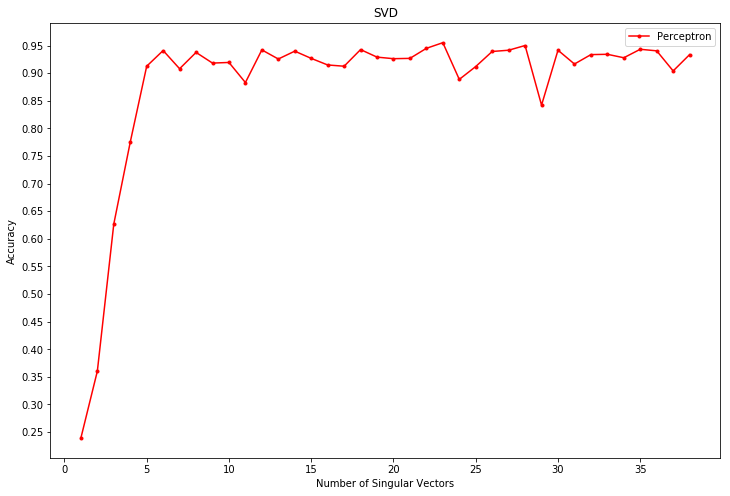

In [153]:
fig, ax = plt.subplots()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(len2,ans2 , '.r-', label='Perceptron')
plt.legend(loc='best')
ax.yaxis.set_major_locator(MultipleLocator(0.05))
fig.set_size_inches(12, 8)
plt.title('SVD')
plt.savefig("q3/q3_a22.jpg")
plt.show()

In [141]:
dataset['label']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [147]:
cans1 = cosine_res
clen1 = singularvector(20,500,3580)

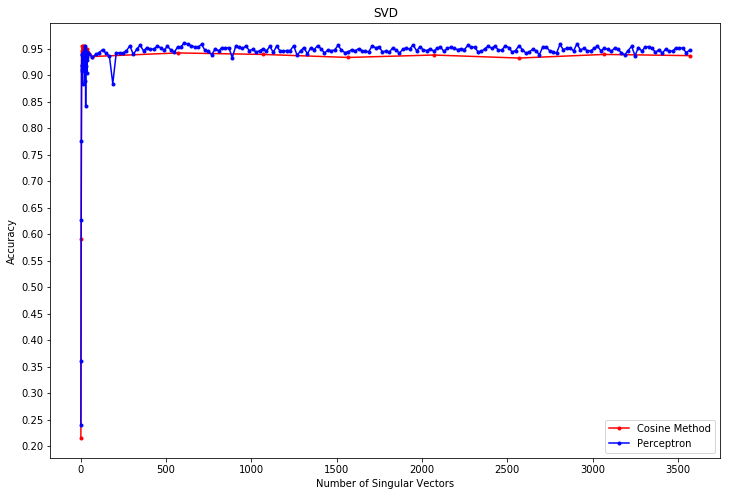

In [182]:
fig, ax = plt.subplots()
plt.xlabel('Number of Singular Vectors')
plt.ylabel('Accuracy')
plt.plot(filen,fians , '.r-', label='Cosine Method')
plt.plot(flen,fans , '.b-', label='Perceptron')
ax.yaxis.set_major_locator(MultipleLocator(0.05))
plt.legend(loc='best')
fig.set_size_inches(12, 8)
plt.title('SVD')
plt.savefig("q3/q3_ans.jpg")
plt.show()

In [149]:
cans1

[[0.93693181818181814],
 [0.93920454545454546],
 [0.93238636363636362],
 [0.93806818181818186],
 [0.93352272727272712],
 [0.93920454545454546],
 [0.94204545454545452],
 [0.93522727272727268]]

In [151]:
clen1

[3568, 3068, 2568, 2068, 1568, 1068, 568, 68]

In [154]:
cans2 = cosine_res
clen2 = singularvector(3550,1,3587)

In [160]:
singularvector(3586,1,3588)

[2, 1]

In [163]:
fians = cans1 + cans2 + cosine_res

In [174]:
filen = clen1 + clen2 + [1]

In [173]:
clen2 = singularvector(3550,3,3587)

In [175]:
len(filen)

22

In [184]:
clen1

[3568, 3068, 2568, 2068, 1568, 1068, 568, 68]

In [185]:
cans1

[[0.93693181818181814],
 [0.93920454545454546],
 [0.93238636363636362],
 [0.93806818181818186],
 [0.93352272727272712],
 [0.93920454545454546],
 [0.94204545454545452],
 [0.93522727272727268]]

In [188]:
def fn():
    return 1,2
a,b = fn()

In [190]:
b

2